In [ ]:
import sys
sys.path.append("/Users/phuchuu/Desktop/Data engineering/Personal Projects/us-dot-flights-lakehouse")
from configs.spark_config import create_spark_session, get_data_paths, stop_spark_session
from configs.data_schema import FLIGHT_DATA_SCHEMA

from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

builder = (SparkSession.builder
            .appName("US_DOT_Flights_Exploration")
            .master("local[*]")
            .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
            .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
            .config("spark.driver.memory", "4g"))

spark = configure_spark_with_delta_pip(builder).getOrCreate()

In [3]:
data_path = get_data_paths()["january_2025"]
airport_lookup_path = get_data_paths()["airport_lookup"]
carrier_lookup_path = get_data_paths()["carrier_lookup"]

data = spark.read.option("timeStampFormat","M/d/yyyy hh:mm:ss a").csv(data_path, schema=FLIGHT_DATA_SCHEMA, header=True)
airport_lookup = spark.read.csv(airport_lookup_path, header=True)   
carrier_lookup = spark.read.csv(carrier_lookup_path, header=True)

airport_lookup.cache()
carrier_lookup.cache()

df = (data
      .join(airport_lookup, data.ORIGIN_AIRPORT_ID == airport_lookup.Code, "left")
      .withColumnRenamed("Description", "ORIGIN_AIRPORT_NAME")
      .drop("Code")
      .join(airport_lookup, data.DEST_AIRPORT_ID == airport_lookup.Code, "left")
      .withColumnRenamed("Description", "DEST_AIRPORT_NAME")
      .drop("Code")
      .join(carrier_lookup, data.OP_UNIQUE_CARRIER == carrier_lookup.Code, "left")
      .withColumnRenamed("Description", "CARRIER_NAME")
      .drop("Code"))

df.show()

25/10/16 20:33:05 WARN BlockManager: Block rdd_23_0 already exists on this machine; not re-adding it


+-------------------+-----------------+-----------------+-----------------+------+---------------+----+------------+--------+---------+-------------+------------+--------+---------+-------------+---------+--------+--------+--------+--------------------+--------------------+--------------------+
|            FL_DATE|OP_UNIQUE_CARRIER|OP_CARRIER_FL_NUM|ORIGIN_AIRPORT_ID|ORIGIN|DEST_AIRPORT_ID|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|DEP_DELAY_NEW|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|ARR_DELAY_NEW|CANCELLED|DIVERTED|AIR_TIME|DISTANCE| ORIGIN_AIRPORT_NAME|   DEST_AIRPORT_NAME|        CARRIER_NAME|
+-------------------+-----------------+-----------------+-----------------+------+---------------+----+------------+--------+---------+-------------+------------+--------+---------+-------------+---------+--------+--------+--------+--------------------+--------------------+--------------------+
|2025-01-01 00:00:00|               AA|                1|            12478|   JFK|          12892| LAX|        0

In [11]:

df.count()

539747

In [12]:
len(df.columns)

22

In [13]:
df.printSchema()

root
 |-- FL_DATE: timestamp (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- DEP_DELAY_NEW: double (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- ARR_DELAY_NEW: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- ORIGIN_AIRPORT_NAME: string (nullable = true)
 |-- DEST_AIRPORT_NAME: string (nullable = true)
 |-- CARRIER_NAME: string (nullable = true)



In [12]:
df.describe()

DataFrame[summary: string, OP_UNIQUE_CARRIER: string, OP_CARRIER_FL_NUM: string, ORIGIN_AIRPORT_ID: string, ORIGIN: string, DEST_AIRPORT_ID: string, DEST: string, CRS_DEP_TIME: string, DEP_TIME: string, DEP_DELAY: string, DEP_DELAY_NEW: string, CRS_ARR_TIME: string, ARR_TIME: string, ARR_DELAY: string, ARR_DELAY_NEW: string, CANCELLED: string, DIVERTED: string, AIR_TIME: string, DISTANCE: string]

In [23]:
# Get the number of elements in each partition
partition_sizes = df.rdd.glom().map(len).collect()
print(f"Partition sizes: {partition_sizes}")

# Count empty partitions
empty_partitions = sum(1 for size in partition_sizes if size == 0)
print(f"Empty partitions: {empty_partitions}")

# Show which partitions are empty
empty_partition_indices = [i for i, size in enumerate(partition_sizes) if size == 0]
print(f"Empty partition indices: {empty_partition_indices}")

Partition sizes: [57530, 58321, 58672, 57321, 57024, 57302, 57961, 57018, 57226, 21372]
Empty partitions: 0
Empty partition indices: []


In [14]:
# Check for null values
for col_name in df.columns:
    null_counts = df.filter(df[col_name].isNull()).count()
    if null_counts > 0:
        null_percentage = (null_counts / df.count()) * 100
        print(f"{col_name}: {null_counts} null values ({null_percentage:.2f}%)")

# Check for duplicate rows
duplicate_count = df.count() - df.distinct().count()
print(f"Number of duplicate rows: {duplicate_count}")

DEP_TIME: 15886 null values (2.94%)
DEP_DELAY: 15923 null values (2.95%)
DEP_DELAY_NEW: 15923 null values (2.95%)
ARR_TIME: 16580 null values (3.07%)
ARR_DELAY: 17478 null values (3.24%)
ARR_DELAY_NEW: 17478 null values (3.24%)
AIR_TIME: 17478 null values (3.24%)


Number of duplicate rows: 0


In [28]:
from pyspark.sql.functions import min, max

date_range = df.select(
    min(df['FL_DATE']).alias('min_date'),
    max(df['FL_DATE']).alias('max_date')
).collect()[0]

print(f"Date range: {date_range['min_date']} to {date_range['max_date']}")


Date range: 2025-01-01 00:00:00 to 2025-01-31 00:00:00


In [30]:
df.filter(df['ARR_DELAY_NEW'] < 0).count()

0

In [31]:
df.filter(df['DEP_DELAY_NEW'] < 0).count()

0

In [38]:
# Check flights per day
flights_per_day = df.groupBy('FL_DATE').count().orderBy('FL_DATE').collect()

for row in flights_per_day:
    print(f"{row['FL_DATE']}: {row['count']} flights")

2025-01-01 00:00:00: 16827 flights
2025-01-02 00:00:00: 19640 flights
2025-01-03 00:00:00: 19358 flights
2025-01-04 00:00:00: 18544 flights
2025-01-05 00:00:00: 19676 flights
2025-01-06 00:00:00: 18732 flights
2025-01-07 00:00:00: 15974 flights
2025-01-08 00:00:00: 16276 flights
2025-01-09 00:00:00: 17952 flights
2025-01-10 00:00:00: 17873 flights
2025-01-11 00:00:00: 14991 flights
2025-01-12 00:00:00: 18359 flights
2025-01-13 00:00:00: 17832 flights
2025-01-14 00:00:00: 15767 flights
2025-01-15 00:00:00: 16044 flights
2025-01-16 00:00:00: 18542 flights
2025-01-17 00:00:00: 18415 flights
2025-01-18 00:00:00: 14690 flights
2025-01-19 00:00:00: 16874 flights
2025-01-20 00:00:00: 18595 flights
2025-01-21 00:00:00: 16034 flights
2025-01-22 00:00:00: 16244 flights
2025-01-23 00:00:00: 18277 flights
2025-01-24 00:00:00: 18142 flights
2025-01-25 00:00:00: 15026 flights
2025-01-26 00:00:00: 18674 flights
2025-01-27 00:00:00: 18007 flights
2025-01-28 00:00:00: 15911 flights
2025-01-29 00:00:00:

In [16]:
# Busiest airports
airports_departure_count = df.groupBy('ORIGIN', 'ORIGIN_AIRPORT_NAME').count().orderBy('count', ascending=False)

airports_departure_count.show(10)

airports_arrival_count = df.groupBy('DEST', 'DEST_AIRPORT_NAME').count().orderBy('count', ascending=False)

airports_arrival_count.show(10)

+------+--------------------+-----+
|ORIGIN| ORIGIN_AIRPORT_NAME|count|
+------+--------------------+-----+
|   DFW|Dallas/Fort Worth...|25124|
|   DEN|Denver, CO: Denve...|24732|
|   ATL|Atlanta, GA: Hart...|23881|
|   ORD|Chicago, IL: Chic...|21643|
|   CLT|Charlotte, NC: Ch...|16877|
|   PHX|Phoenix, AZ: Phoe...|15956|
|   LAX|Los Angeles, CA: ...|15157|
|   LAS|Las Vegas, NV: Ha...|15007|
|   MCO|Orlando, FL: Orla...|13058|
|   SEA|Seattle, WA: Seat...|11882|
+------+--------------------+-----+
only showing top 10 rows

+----+--------------------+-----+
|DEST|   DEST_AIRPORT_NAME|count|
+----+--------------------+-----+
| DFW|Dallas/Fort Worth...|25125|
| DEN|Denver, CO: Denve...|24740|
| ATL|Atlanta, GA: Hart...|23881|
| ORD|Chicago, IL: Chic...|21641|
| CLT|Charlotte, NC: Ch...|16883|
| PHX|Phoenix, AZ: Phoe...|15949|
| LAX|Los Angeles, CA: ...|15143|
| LAS|Las Vegas, NV: Ha...|15004|
| MCO|Orlando, FL: Orla...|13052|
| SEA|Seattle, WA: Seat...|11893|
+----+--------------------+-

In [ ]:
# Most active airlines
airlines_count = df.groupBy('CARRIER_NAME').count().orderBy('count', ascending=False)

airlines_count.show(10)


+--------------------+------+
|        CARRIER_NAME| count|
+--------------------+------+
|Southwest Airline...|105307|
|Delta Air Lines Inc.| 76306|
|American Airlines...| 75088|
|SkyWest Airlines ...| 65036|
|United Air Lines ...| 62007|
|    Republic Airline| 27833|
|           Envoy Air| 21890|
|   PSA Airlines Inc.| 21094|
|Alaska Airlines Inc.| 18163|
|     JetBlue Airways| 17918|
+--------------------+------+
only showing top 10 rows



In [18]:
num_cancelled_flights = df.filter(df['CANCELLED'] == 1).count()

print(f"Number of cancelled flights: {num_cancelled_flights}")

num_cancelled_flights_percentage = (num_cancelled_flights / df.count()) * 100

print(f"Number of cancelled flights percentage: {num_cancelled_flights_percentage:.2f}%")

Number of cancelled flights: 16312
Number of cancelled flights percentage: 3.02%


In [19]:
num_diverted_flights = df.filter(df['DIVERTED'] == 1).count()

print(f"Number of diverted flights: {num_diverted_flights}")

num_diverted_flights_percentage = (num_diverted_flights / df.count()) * 100

print(f"Number of diverted flights percentage: {num_diverted_flights_percentage:.2f}%")

Number of diverted flights: 1166
Number of diverted flights percentage: 0.22%


In [18]:
arr_delay_avg = df.filter(df['ARR_DELAY_NEW'] > 0).groupBy().avg('ARR_DELAY_NEW')

arr_delay_avg.show()

dep_delay_avg = df.filter(df['DEP_DELAY_NEW'] > 0).groupBy().avg('DEP_DELAY_NEW')

dep_delay_avg.show()

num_flights_delay = df.filter(df['DEP_DELAY_NEW'] > 0).count()

print("Number of flights with delay: ", num_flights_delay)
print("Percentage of flights with delay: ", (num_flights_delay / df.count()) * 100)

+------------------+
|avg(ARR_DELAY_NEW)|
+------------------+
|43.141501048607765|
+------------------+

+------------------+
|avg(DEP_DELAY_NEW)|
+------------------+
|41.675384511145744|
+------------------+

Number of flights with delay:  177108
Percentage of flights with delay:  32.813151346834715


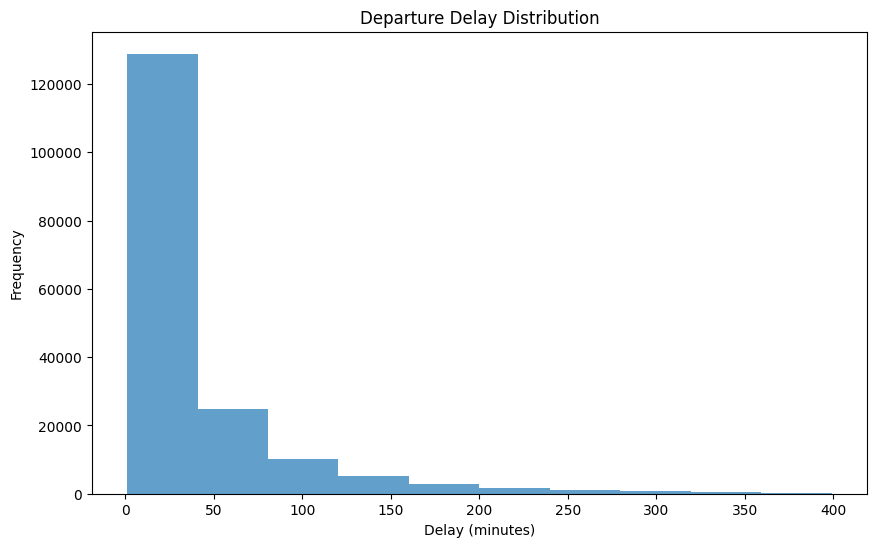

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas and create histogram
df_pandas = df.filter(df['DEP_DELAY_NEW'] > 0).filter(df['DEP_DELAY_NEW'] < 400).select("DEP_DELAY_NEW").toPandas()
plt.figure(figsize=(10, 6))
plt.hist(df_pandas["DEP_DELAY_NEW"].dropna(), bins=10, alpha=0.7)
plt.title("Departure Delay Distribution")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.show()

In [24]:
# Most popular routes
routes_count = df.groupBy('ORIGIN_AIRPORT_NAME', 'DEST_AIRPORT_NAME').count().orderBy('count', ascending=False)

routes_count.show(10)

+--------------------+--------------------+-----+
| ORIGIN_AIRPORT_NAME|   DEST_AIRPORT_NAME|count|
+--------------------+--------------------+-----+
|Kahului, HI: Kahu...|Honolulu, HI: Dan...|  986|
|Honolulu, HI: Dan...|Kahului, HI: Kahu...|  985|
|Chicago, IL: Chic...|New York, NY: LaG...|  923|
|New York, NY: LaG...|Chicago, IL: Chic...|  919|
|Los Angeles, CA: ...|San Francisco, CA...|  852|
|San Francisco, CA...|Los Angeles, CA: ...|  849|
|Phoenix, AZ: Phoe...|Denver, CO: Denve...|  806|
|Denver, CO: Denve...|Phoenix, AZ: Phoe...|  800|
|Boston, MA: Logan...|Washington, DC: R...|  776|
|Los Angeles, CA: ...|New York, NY: Joh...|  775|
+--------------------+--------------------+-----+
only showing top 10 rows



In [25]:
# Average distance of flights
avg_distance = df.groupBy().avg('DISTANCE')

avg_distance.show()

# Average duration of flights
avg_duration = df.groupBy().avg('AIR_TIME')

avg_duration.show()


+-----------------+
|    avg(DISTANCE)|
+-----------------+
|843.2082160716039|
+-----------------+

+-----------------+
|    avg(AIR_TIME)|
+-----------------+
|118.0350489881651|
+-----------------+



In [ ]:
delay_avg_routes = df.filter(df['DEP_DELAY_NEW'] > 0).groupBy('ORIGIN_AIRPORT_NAME', 'DEST_AIRPORT_NAME').avg('DEP_DELAY_NEW').orderBy('avg(DEP_DELAY_NEW)', ascending=False)

delay_avg_routes.show()

+--------------------+--------------------+------------------+
| ORIGIN_AIRPORT_NAME|   DEST_AIRPORT_NAME|avg(DEP_DELAY_NEW)|
+--------------------+--------------------+------------------+
|Portsmouth, NH: P...|Sanford, FL: Orla...|             943.0|
|Albany, NY: Alban...|Nashville, TN: Na...|             885.0|
|Savannah, GA: Sav...|St. Petersburg, F...|             692.0|
|Valparaiso, FL: E...|Las Vegas, NV: Ha...|             611.0|
|Scranton/Wilkes-B...|Chicago, IL: Chic...| 576.3333333333334|
|St. Petersburg, F...|Evansville, IN: E...|             547.0|
|Phoenix, AZ: Mesa...|Missoula, MT: Mis...|             545.0|
|Evansville, IN: E...|St. Petersburg, F...|             540.0|
|Portland, OR: Por...|Provo, UT: Provo ...|             524.0|
|Idaho Falls, ID: ...|Las Vegas, NV: Ha...|             524.0|
|Kalispell, MT: Gl...|Las Vegas, NV: Ha...|             511.0|
|Hartford, CT: Bra...|Miami, FL: Miami ...| 504.3333333333333|
|Pasco/Kennewick/R...|Minneapolis, MN: ...|            

25/10/17 01:23:12 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1005603 ms exceeds timeout 120000 ms
25/10/17 01:23:12 WARN SparkContext: Killing executors is not supported by current scheduler.
25/10/17 01:23:26 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 

# 📊 Data Exploration Findings Summary

## A. Data Overview

### Dataset Characteristics
- **Total Records**: 539,847 flights
- **Date Range**: January 1-31, 2025 (31 days)
- **Columns**: 23 fields including flight details, delays, and airport information
- **Partitions**: 10 partitions with good data distribution (no empty partitions)
- **Data Quality**: No duplicate records found

### Data Volume Insights
- **Average flights per day**: ~17,414 flights
- **Peak day**: January 5th (19,676 flights)
- **Lowest day**: January 7th (15,974 flights)
- **Weekend pattern**: Lower flight volumes on weekends (Saturday-Sunday)

## B. Data Quality Issues Found

### Missing Values Analysis
- **DEP_TIME**: 15,886 nulls (2.94%) - Critical field
- **DEP_DELAY**: 15,923 nulls (2.95%) - Critical field  
- **DEP_DELAY_NEW**: 15,923 nulls (2.95%) - Critical field
- **ARR_TIME**: 16,580 nulls (3.07%) - Critical field
- **ARR_DELAY**: 17,478 nulls (3.24%) - Critical field
- **ARR_DELAY_NEW**: 17,478 nulls (3.24%) - Critical field
- **AIR_TIME**: 17,478 nulls (3.24%) - Important field

### Data Quality Concerns
1. **High null percentage in time fields** (~3%) - likely due to cancelled/diverted flights
2. **Negative delays** - Early departures/arrivals (normal but need handling)
3. **Time format inconsistencies** - Times stored as strings (HHMM format)
4. **Missing airport names** - Some airport codes don't have corresponding names

## C. Business Insights

### Airport Performance
**Top 10 Busiest Airports (Departures):**
1. Dallas/Fort Worth (DFW): 25,124 flights
2. Denver (DEN): 24,732 flights  
3. Atlanta (ATL): 23,881 flights
4. Chicago O'Hare (ORD): 21,643 flights
5. Charlotte (CLT): 16,877 flights

### Airline Performance
**Top 10 Airlines by Volume:**
1. Southwest Airlines: 105,307 flights (19.5%)
2. Delta Air Lines: 76,306 flights (14.1%)
3. American Airlines: 75,088 flights (13.9%)
4. SkyWest Airlines: 65,036 flights (12.1%)
5. United Air Lines: 62,007 flights (11.5%)

### Operational Metrics
- **Cancellation Rate**: 3.02% (16,312 flights)
- **Diversion Rate**: 0.22% (1,166 flights)
- **Delay Rate**: 32.81% (177,108 flights with delays)
- **Average Departure Delay**: 41.68 minutes (for delayed flights)
- **Average Arrival Delay**: 43.14 minutes (for delayed flights)

### Route Analysis
**Most Popular Routes:**
1. Kahului ↔ Honolulu: 1,971 flights (inter-island)
2. Chicago ↔ New York (LaGuardia): 1,842 flights
3. Los Angeles ↔ San Francisco: 1,701 flights
4. Phoenix ↔ Denver: 1,606 flights
5. Boston ↔ Washington (Reagan): 1,552 flights

**Average Flight Characteristics:**
- **Distance**: 843.2 miles
- **Air Time**: 118.0 minutes

## D. Schema Recommendations

### Bronze Layer Schema
```python
bronze_schema = {
    # Core identifiers
    "flight_date": "date",
    "airline_code": "string",
    "flight_number": "integer", 
    "origin_airport": "string",
    "dest_airport": "string",
    
    # Time fields (keep as strings for now)
    "crs_dep_time": "string",
    "dep_time": "string", 
    "crs_arr_time": "string",
    "arr_time": "string",
    
    # Delay metrics
    "dep_delay": "double",
    "dep_delay_new": "double",
    "arr_delay": "double", 
    "arr_delay_new": "double",
    
    # Operational status
    "cancelled": "double",
    "diverted": "double",
    
    # Flight details
    "air_time": "double",
    "distance": "double",
    
    # Enriched data
    "origin_airport_name": "string",
    "dest_airport_name": "string", 
    "carrier_name": "string",
    
    # Metadata
    "ingestion_timestamp": "timestamp",
    "source_file": "string",
    "data_quality_score": "double"
}
```

### Data Type Optimizations
- **Dates**: Convert to proper date type
- **Times**: Convert HHMM strings to time type
- **Delays**: Use double for precision
- **Flags**: Use boolean for cancelled/diverted
- **IDs**: Use integer for airport/carrier IDs

## E. Data Quality Rules for Pipeline

### Completeness Rules
- Flight date, airline, origin, destination must not be null
- Acceptable null rate: <5% for time fields
- Acceptable null rate: <1% for distance/air_time

### Validity Rules  
- Airport codes: Exactly 3 characters
- Airline codes: Valid against carrier lookup
- Flight numbers: Positive integers
- Delays: Between -60 and +300 minutes
- Distance: Positive values
- Air time: Positive values

### Consistency Rules
- Departure time < arrival time (same day)
- Air time < 24 hours
- Distance matches expected route distance
- Delay correlation: dep_delay and arr_delay should be correlated

### Business Rules
- Cancelled flights should have null times
- Diverted flights should have valid times
- Early departures (negative delays) are valid
- Extreme delays (>300 min) need investigation

## F. Partitioning Strategy

### Recommended Partitioning
- **Primary**: `flight_date` (year=YYYY, month=MM, day=DD)
- **Secondary**: `airline_code` (for airline-specific analysis)
- **Z-Order**: `(flight_date, origin_airport)` for time-series queries

### Performance Considerations
- Current data: ~540K records/month
- Expected growth: ~6.5M records/year
- Partition size: ~17K records/day (optimal for Spark)
- Z-ordering will improve query performance for time-series analysis

## G. Next Steps for Pipeline Development

1. **Bronze Layer**: Implement data ingestion with schema validation
2. **Data Quality**: Add Great Expectations suite based on rules above
3. **Silver Layer**: Clean and standardize data, handle nulls appropriately
4. **Gold Layer**: Create analytics tables for business intelligence
5. **Monitoring**: Set up data quality dashboards and alerts

## H. Key Metrics to Track

### Operational Metrics
- Daily flight volume trends
- Cancellation rates by airline/airport
- Average delays by route/time
- On-time performance by carrier

### Data Quality Metrics  
- Null percentage by field
- Data freshness (ingestion lag)
- Schema validation success rate
- Duplicate detection rate

### Business Metrics
- Route profitability analysis
- Airport efficiency rankings
- Seasonal demand patterns
- Delay impact on operations